In [12]:
from timm import create_model

model = create_model("densenet121")
print("{:,}".format(sum([p.data.nelement() for p in model.parameters()])))

7,978,856


1001
BC_01_2993.npy


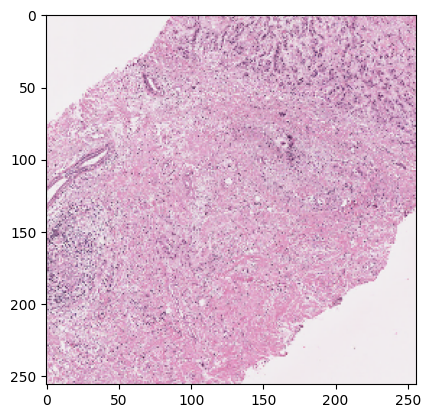

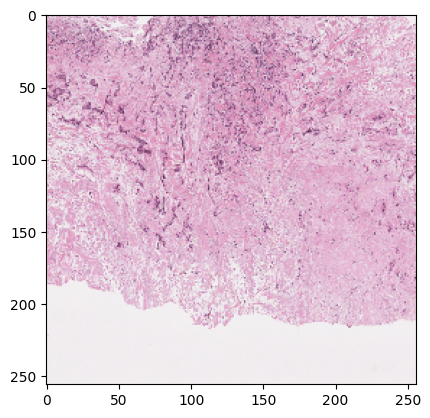

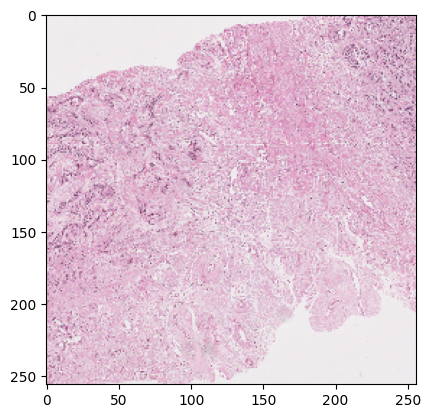

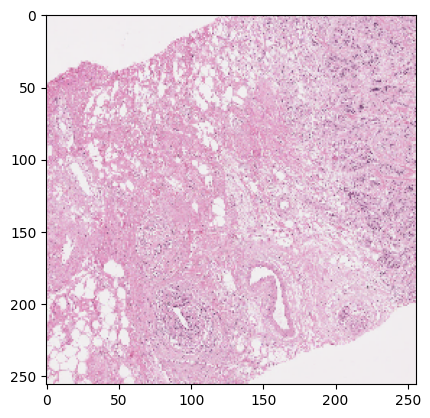

In [6]:
import os
data_path = "/home/ljj0512/shared/data/refine_train_img/"
print(len(os.listdir(data_path)))
img_list = os.listdir(data_path)
print(img_list[0])

import numpy as np
import matplotlib.pyplot as plt
img = np.load(os.path.join(data_path,img_list[0]))
plt.imshow(img[0])
plt.show()
plt.imshow(img[1])
plt.show()
plt.imshow(img[2])
plt.show()
plt.imshow(img[3])
plt.show()

In [1]:
import numpy as np
def make_tiles(img, tile_size=256, num_tiles=4):
    '''
    img: np.ndarray with dtype np.uint8 and shape (width, height, channel)
    '''
    w, h, ch = img.shape
    pad0, pad1 = (tile_size - w%tile_size) % tile_size, (tile_size - h%tile_size) % tile_size
    padding = [[pad0//2, pad0-pad0//2], [pad1//2, pad1-pad1//2], [0, 0]]
    img = np.pad(img, padding, mode='constant', constant_values=255)
    img = img.reshape(img.shape[0]//tile_size, tile_size, img.shape[1]//tile_size, tile_size, ch)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, tile_size, tile_size, ch)
    if len(img) < num_tiles: # pad images so that the output shape be the same
        padding = [[0, num_tiles-len(img)], [0, 0], [0, 0], [0, 0]]
        img = np.pad(img, padding, mode='constant', constant_values=255)
    idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:num_tiles] # pick up Top N dark tiles
    img = img[idxs]
    return img

In [47]:
import random
import pandas as pd
import numpy as np
import os
import cv2
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.models as models

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore') 

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

CFG = {
    'IMG_SIZE':512,
    'EPOCHS':5,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':16,
    'SEED':41
}

root_dir = "/home/ljj0512/private/workspace/CP_Multi-modal_Cencer-metastasis_DACON/data"
train_df = pd.read_csv(root_dir+'/train.csv')
test_df = pd.read_csv(root_dir+'/test.csv')

train_df['암의 장경'] = train_df['암의 장경'].fillna(train_df['암의 장경'].mean())
train_df = train_df.fillna(0)

test_df['암의 장경'] = test_df['암의 장경'].fillna(train_df['암의 장경'].mean())
test_df = test_df.fillna(0)

train_df, val_df, train_labels, val_labels = train_test_split(train_df.drop(columns=['N_category']), 
                                                                train_df['N_category'], 
                                                                test_size=0.2, 
                                                                random_state=CFG["SEED"])

In [34]:
print(train_df.shape)
print(train_labels.shape)
print(val_df.shape)
print(val_labels.shape)

(800, 27)
(800,)
(200, 27)
(200,)


In [8]:

def get_values(value):
    return value.values.reshape(-1, 1)

numeric_cols = ['나이', '암의 장경', 'ER_Allred_score', 'PR_Allred_score', 'KI-67_LI_percent', 'HER2_SISH_ratio']
ignore_cols = ['ID', 'img_path', 'mask_path', '수술연월일', 'N_category']

for col in train_df.columns:
    if col in ignore_cols:
        continue
    if col in numeric_cols:
        scaler = StandardScaler()
        train_df[col] = scaler.fit_transform(get_values(train_df[col]))
        val_df[col] = scaler.transform(get_values(val_df[col]))
        test_df[col] = scaler.transform(get_values(test_df[col]))
    else:
        le = LabelEncoder()
        train_df[col] = le.fit_transform(get_values(train_df[col]))
        val_df[col] = le.transform(get_values(val_df[col]))
        test_df[col] = le.transform(get_values(test_df[col]))

In [44]:
len(train_df.drop(columns=['ID', 'img_path', 'mask_path', '수술연월일']).iloc[0])

23

In [45]:
train_df.iloc[0]

ID                                    BC_01_3277
img_path             ./train_imgs/BC_01_3277.png
mask_path                                      -
나이                                     -2.522114
수술연월일                                 2010-02-05
진단명                                            0
암의 위치                                          1
암의 개수                                          0
암의 장경                                  -0.793655
NG                                             3
HG                                             3
HG_score_1                                     3
HG_score_2                                     3
HG_score_3                                     3
DCIS_or_LCIS_여부                                0
DCIS_or_LCIS_type                              0
T_category                                     1
ER                                             1
ER_Allred_score                         0.017689
PR                                             1
PR_Allred_score     

In [29]:
class CustomDataset(Dataset):
    def __init__(self, medical_df, labels, transforms=None):
        self.medical_df = medical_df
        self.transforms = transforms
        self.labels = labels
        
    def __getitem__(self, index):
        root_dir = "/home/ljj0512/private/workspace/CP_Multi-modal_Cencer-metastasis_DACON/data"
        img_path = self.medical_df['img_path'].iloc[index][2:]
        image = cv2.imread(os.path.join(root_dir,img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
                
        if self.labels is not None:
            tabular = torch.Tensor(self.medical_df.drop(columns=['ID', 'img_path', 'mask_path', '수술연월일']).iloc[index])
            label = self.labels[index]
            return image, tabular, label
        else:
            tabular = torch.Tensor(self.medical_df.drop(columns=['ID', 'img_path', '수술연월일']).iloc[index])
            return image, tabular
        
    def __len__(self):
        return len(self.medical_df)

In [30]:
train_transforms = A.Compose([
                            A.HorizontalFlip(),
                            A.VerticalFlip(),
                            A.Rotate(limit=90, border_mode=cv2.BORDER_CONSTANT,p=0.3),
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transforms = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [31]:
train_dataset = CustomDataset(train_df, train_labels.values, train_transforms)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_df, val_labels.values, test_transforms)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [39]:
print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)
print(train_dataset[0][2])

torch.Size([3, 512, 512])
torch.Size([23])
()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


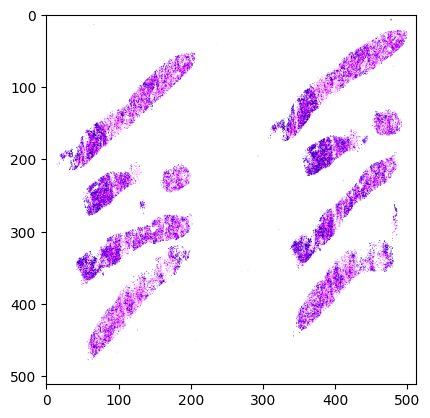

tensor([[ 7.1698e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00, -4.4193e-01,
          2.0000e+00,  2.0000e+00,  2.0000e+00,  2.0000e+00,  2.0000e+00,
          2.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00,  6.1988e-01,
          1.0000e+00,  7.0276e-01, -1.3982e-01,  0.0000e+00,  2.0000e+00,
          0.0000e+00,  6.9744e-01,  0.0000e+00],
        [-7.7125e-01,  3.0000e+00,  0.0000e+00,  1.0000e+00, -9.0205e-02,
          2.0000e+00,  1.0000e+00,  2.0000e+00,  2.0000e+00,  1.0000e+00,
          2.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00,  6.1988e-01,
          1.0000e+00,  1.6783e-01,  2.9825e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -2.5997e-01,  0.0000e+00],
        [ 6.2943e-01,  0.0000e+00,  0.0000e+00,  1.0000e+00,  7.0118e-01,
          3.0000e+00,  3.0000e+00,  3.0000e+00,  3.0000e+00,  3.0000e+00,
          0.0000e+00,  0.0000e+00,  2.0000e+00,  1.0000e+00,  6.1988e-01,
          0.0000e+00, -9.0202e-01,  2.7476e+00,  0.0000e+00,  1.0000e+00,
          0.00

In [48]:
for image, tabular, label in train_loader:
    plt.imshow(image[0].permute(1,2,0))
    plt.show()
    print(tabular)
    print(label)
    break

In [28]:
import os
print(os.path.join(root_dir,train_df["img_path"].iloc[0][2:]))

/home/ljj0512/private/workspace/CP_Multi-modal_Cencer-metastasis_DACON/data/train_imgs/BC_01_3277.png
